# Семинар 6

Линеаризация, метрика квантиля, тест на разность дисперсий, поправки на множественное тестирование

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
def plot_pvalue_distribution(dict_pvalues):
    """Рисует графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], "--k", alpha=0.8)
    plt.title("Оценка распределения p-value", size=16)
    plt.xlabel("p-value", size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

### Какие методы работы с ratio метриками мы уже знаем?

- Бутстреп 
- Дельта-метод
- Бакетизация

## Линеаризация

Линеаризация -- переход к пользовательской метрике через другое признаковое пространство, показывающий отклонение от поведения
“усредненного” пользователя контрольной группы

$$L(X(u_i), Y(u_i)) = X(u_i) - R_{U_{c}} Y(u_i)$$

Переход от ratio к линеаризованной метрике:

$$R = \frac{\Sigma_{u\in U}X(u)}{\Sigma_{u\in U}Y(u)} \rightarrow Lin=\frac{\Sigma_{u\in U}L(X(u), Y(u))}{\# U}$$

### Симуляция

- 2 группы по 1000 человек
- Каждый покупатель совершает от 1 до 5 покупок
- Значения среднего чека рандомное от 1000 до 2000

In [26]:
def generate_data(sample_size, effect):
    """Генерирует данные со стоимостью покупок.

    Возвращает два списка с данными контрольной и экспериментальной групп.
    Элементы списков - множества со стоимостями покупок пользователей.
    """
    result = []
    for group_effect in [0, effect]:
        n_purchases = np.random.randint(1, 5, sample_size)
        mean_costs = np.random.uniform(1000, 2000, sample_size)
        data = [
            np.random.normal(loc=mean + group_effect, scale=200, size=n)
            for n, mean in zip(n_purchases, mean_costs)
        ]
        result.append(data)
    return result


a, b = generate_data(10, 0)

print(a[0])
print(b[0])

[1264.65311438 1753.01790196]
[1028.3614629   606.91390594  966.30267604]


In [27]:
def check_linearization(a: list[np.array], b: list[np.array]) -> tuple[float, float]:
    """Проверка гипотезы с помощью линеаризации."""
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return delta, pvalue

In [28]:
alpha = 0.05  # допустимая вероятность ошибки I рода
sample_size = 1000  # размер групп
effect = 50  # размер эффекта

pvalues_aa = []
pvalues_ab = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    _, pvalue = check_linearization(a, b)
    pvalues_aa.append(pvalue)

    a, b = generate_data(sample_size, effect)
    _, pvalue = check_linearization(a, b)
    pvalues_ab.append(pvalue)

error_rate = np.mean(np.array(pvalues_aa) < alpha)
print(f"Доля ошибок первого рода: {error_rate:0.2f}")

Доля ошибок первого рода: 0.05


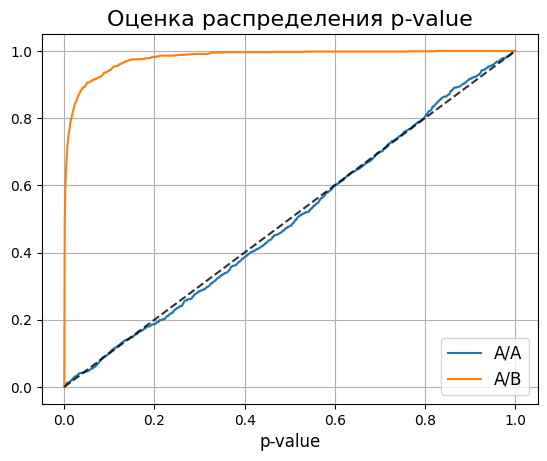

In [29]:
plot_pvalue_distribution({"A/A": pvalues_aa, "A/B": pvalues_ab})

> Q: Что значит, что линеаризованная метрика обладает свойством сонаправленности?


### Сонаправленность линеаризации
Проведем A/A симуляцию, проверим направленность **разности средних** и **p-value** у трех способов: 
- бутстрапа
- усреднения по пользователям (user average)
- линеаризации

Если методы проверяют одну и ту же гипотезу, то их дельты и p-value должны быть практически идеально сонаправлены, образуя диагональную линию.  

In [141]:
# source: https://habr.com/ru/companies/ozontech/articles/712306/


def classic_bootstrap_ratio(a, b, n=1000):
    len_a = len(a)
    len_b = len(b)

    list_diff_mean = []
    for _ in range(n):
        a_bootstrap_index = np.random.choice(np.arange(len_a), len_a, replace=True)
        b_bootstrap_index = np.random.choice(np.arange(len_b), len_b, replace=True)
        a_bootstrap_sample = a[a_bootstrap_index]
        b_bootstrap_sample = b[b_bootstrap_index]

        # считаем ratio-метрики
        b_mean = np.sum(b_bootstrap_sample[:, 0]) / np.sum(b_bootstrap_sample[:, 1])
        a_mean = np.sum(a_bootstrap_sample[:, 0]) / np.sum(a_bootstrap_sample[:, 1])

        # считаем разность ratio-метрик бутстрап подвыборок
        list_diff_mean.append(b_mean - a_mean)

    # считаем реальную разность двух групп
    delta_mean = np.sum(b[:, 0]) / np.sum(b[:, 1]) - np.sum(a[:, 0]) / np.sum(a[:, 1])
    std_delta_mean = np.std(list_diff_mean)

    # считаем p-value
    pvalue_delta_mean = 2 * (1 - stats.norm.cdf(np.abs(delta_mean / std_delta_mean)))

    return delta_mean, pvalue_delta_mean


def ttest_user_average(a, b):
    pvalue = stats.ttest_ind(a[:, 0] / a[:, 1], b[:, 0] / b[:, 1], equal_var=False)[1]
    delta = np.mean(b[:, 0] / b[:, 1]) - np.mean(a[:, 0] / a[:, 1])
    return delta, pvalue


def ttest_lin(a, b):
    k = np.sum(a[:, 0]) / np.sum(a[:, 1])
    a_lin = a[:, 0] - k * a[:, 1]
    b_lin = b[:, 0] - k * b[:, 1]
    pvalue = stats.ttest_ind(a_lin, b_lin)[1]
    delta_lin = np.mean(b_lin) - np.mean(a_lin)
    return delta_lin, pvalue


# Define the methods and results dictionary
dict_check = {
    "user_average": ttest_user_average,
    "classic_bootstrap": classic_bootstrap_ratio,
    "linearization": ttest_lin,
}

res_dict = {key: {"pvalue": [], "delta": []} for key in dict_check}

# Simulate data and apply the methods
for _ in range(200):
    a_num = np.random.normal(1200, 200, 1000)
    a_denom = np.random.poisson(2, 1000)
    a_denom[a_denom == 0] = 1

    b_num = np.random.normal(1200, 200, 1000)
    b_denom = np.random.poisson(2, 1000)
    b_denom[b_denom == 0] = 1

    a = np.column_stack((a_num, a_denom))
    b = np.column_stack((b_num, b_denom))

    for method_name, method_func in dict_check.items():
        delta, pvalue = method_func(a, b)
        res_dict[method_name]["delta"].append(delta)
        res_dict[method_name]["pvalue"].append(pvalue)

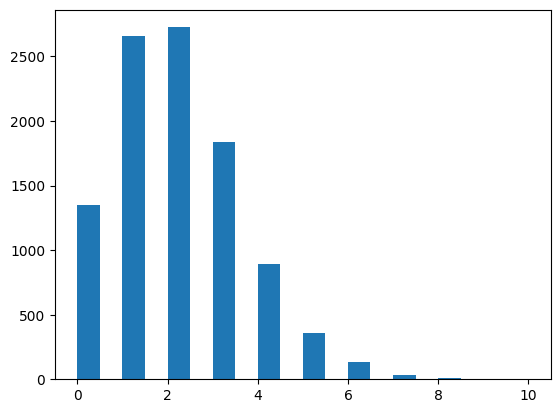

In [72]:
plt.hist(np.random.poisson(2, 10000), bins=20)

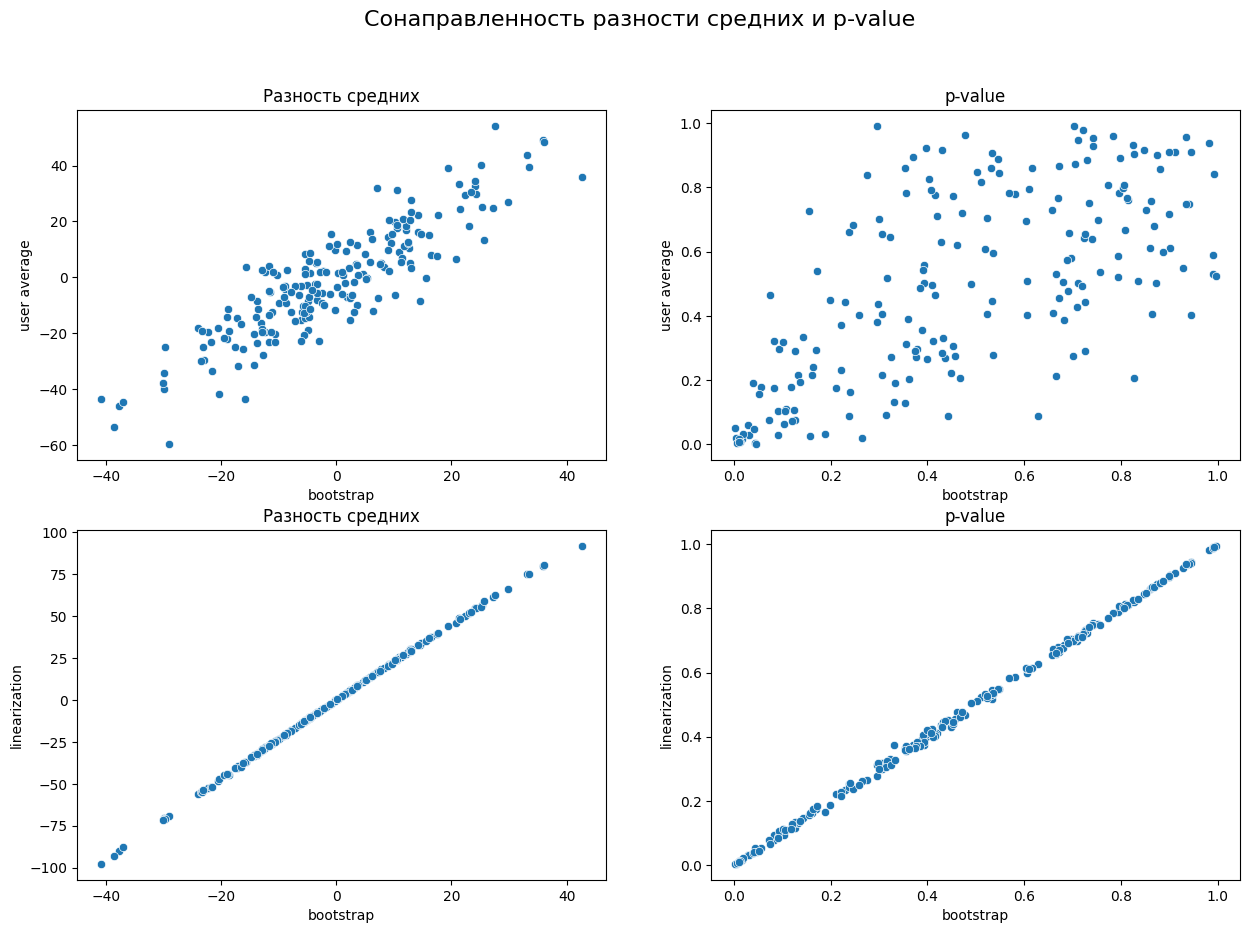

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

subplot_titles = ["Разность средних", "p-value", "Разность средних", "p-value"]

# Scatterplot 1: user_average delta vs classic_bootstrap delta
sns.scatterplot(
    x=res_dict["classic_bootstrap"]["delta"],
    y=res_dict["user_average"]["delta"],
    ax=axes[0, 0],
)
axes[0, 0].set_title(subplot_titles[0])
axes[0, 0].set_xlabel("bootstrap")
axes[0, 0].set_ylabel("user average")

# Scatterplot 2: user_average pvalue vs classic_bootstrap pvalue
sns.scatterplot(
    x=res_dict["classic_bootstrap"]["pvalue"],
    y=res_dict["user_average"]["pvalue"],
    ax=axes[0, 1],
)
axes[0, 1].set_title(subplot_titles[1])
axes[0, 1].set_xlabel("bootstrap")
axes[0, 1].set_ylabel("user average")

# Scatterplot 3: linearization delta vs classic_bootstrap delta
sns.scatterplot(
    x=res_dict["classic_bootstrap"]["delta"],
    y=res_dict["linearization"]["delta"],
    ax=axes[1, 0],
)
axes[1, 0].set_title(subplot_titles[2])
axes[1, 0].set_xlabel("bootstrap")
axes[1, 0].set_ylabel("linearization")

# Scatterplot 4: linearization pvalue vs classic_bootstrap pvalue
sns.scatterplot(
    x=res_dict["classic_bootstrap"]["pvalue"],
    y=res_dict["linearization"]["pvalue"],
    ax=axes[1, 1],
)
axes[1, 1].set_title(subplot_titles[3])
axes[1, 1].set_xlabel("bootstrap")
axes[1, 1].set_ylabel("linearization")

# Adjust layout for better spacing
# fig.tight_layout()

fig.suptitle("Сонаправленность разности средних и p-value", fontsize=16)

plt.show()

### Альтернативные способы посчитать $p$ в формуле линеаризации

$$L(X(u_i), Y(u_i)) = X(u_i) - р Y(u_i)$$

При применении линеаризации $p$ обычно рассчитывается как **CTR контрольной группы**. 

Но если
- контрольная группа маленькая
- контрольная группа сильно несбалансирована
- дисперсии в группах сильно отличаются

, то можно и по-другому:

#### 1. Pooled CTR (считаем по обеим группам)
$$
p = \frac{\text{total clicks in both control and treatment}}{\text{total impressions in both control and treatment}}
$$

**Пример использования**: когда ожидается, что эффект тритмента будет небольшим, и данные обеих групп можно объединить


#### 2. Взвешенный CTR
$$
p = \frac{(\text{control clicks} \times \text{control impressions}) + (\text{treatment clicks} \times \text{treatment impressions})}{\text{control impressions} + \text{treatment impressions}}
$$

**Пример использования**: когда контрольная и тритмент группы сильно отличаются по размеру

#### 3. Когортный CTR
$$
p_{\text{segment}} = \frac{\text{clicks in segment}}{\text{impressions in segment}}
$$

**Пример использования**: когда вы ожидаете разного поведения для различных сегментов пользователей (например, новых и вернувшихся пользователей или разных регионов)

#### 4. Историческое значение CTR

**Пример использования**: когда обе группы маленькие и оценки шумные.

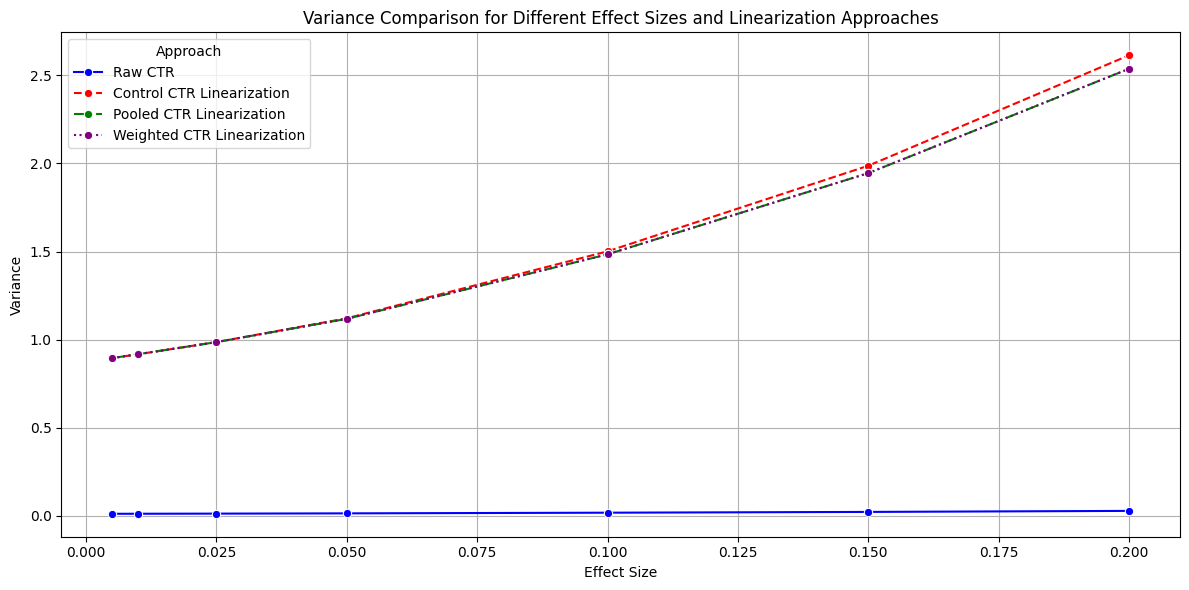

In [19]:
# Function to generate synthetic A/B test data
def generate_data_ctr(
    n_control=10000, n_treatment=10000, ctr_control=0.1, ctr_treatment=0.105
):
    np.random.seed(42)
    impressions_control = np.random.poisson(10, n_control)
    impressions_treatment = np.random.poisson(10, n_treatment)
    clicks_control = np.random.binomial(impressions_control, ctr_control)
    clicks_treatment = np.random.binomial(impressions_treatment, ctr_treatment)

    control = pd.DataFrame(
        {
            "group": "control",
            "impressions": impressions_control,
            "clicks": clicks_control,
        }
    )
    treatment = pd.DataFrame(
        {
            "group": "treatment",
            "impressions": impressions_treatment,
            "clicks": clicks_treatment,
        }
    )

    return pd.concat([control, treatment], ignore_index=True)


# Function to calculate CTR baselines
def compute_ctr_baselines(data):
    ctr_control = (
        data[data["group"] == "control"]["clicks"].sum()
        / data[data["group"] == "control"]["impressions"].sum()
    )
    ctr_treatment = (
        data[data["group"] == "treatment"]["clicks"].sum()
        / data[data["group"] == "treatment"]["impressions"].sum()
    )
    pooled_ctr = data["clicks"].sum() / data["impressions"].sum()
    weighted_ctr = (
        ctr_control * len(data[data["group"] == "control"])
        + ctr_treatment * len(data[data["group"] == "treatment"])
    ) / len(data)
    return ctr_control, pooled_ctr, weighted_ctr


# Function to apply linearization
def apply_linearization(data, p):
    return data["clicks"] - p * data["impressions"]


# Function to compare variances
def compare_variances(data, ctr_control, pooled_ctr, weighted_ctr):
    data["linearized_control"] = apply_linearization(data, ctr_control)
    data["linearized_pooled"] = apply_linearization(data, pooled_ctr)
    data["linearized_weighted"] = apply_linearization(data, weighted_ctr)

    variance_dict = {
        "Raw CTR": data["clicks"].div(data["impressions"]).var(),
        "Control CTR Linearization": data["linearized_control"].var(),
        "Pooled CTR Linearization": data["linearized_pooled"].var(),
        "Weighted CTR Linearization": data["linearized_weighted"].var(),
    }

    return variance_dict


# Simulate and compare variance for different effect sizes
def simulate_effect_size_comparison():
    effect_sizes = [0.005, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2]
    variance_results = {
        "Effect Size": [],
        "Raw CTR": [],
        "Control CTR Linearization": [],
        "Pooled CTR Linearization": [],
        "Weighted CTR Linearization": [],
    }

    for effect_size in effect_sizes:
        data = generate_data_ctr(ctr_control=0.1, ctr_treatment=0.1 + effect_size)
        ctr_control, pooled_ctr, weighted_ctr = compute_ctr_baselines(data)
        variance_dict = compare_variances(data, ctr_control, pooled_ctr, weighted_ctr)
        variance_results["Effect Size"].append(effect_size)
        variance_results["Raw CTR"].append(variance_dict["Raw CTR"])
        variance_results["Control CTR Linearization"].append(
            variance_dict["Control CTR Linearization"]
        )
        variance_results["Pooled CTR Linearization"].append(
            variance_dict["Pooled CTR Linearization"]
        )
        variance_results["Weighted CTR Linearization"].append(
            variance_dict["Weighted CTR Linearization"]
        )

    return pd.DataFrame(variance_results)


# Run the simulation and comparison
variance_comparison_df = simulate_effect_size_comparison()

# Plot the results as a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=variance_comparison_df,
    x="Effect Size",
    y="Raw CTR",
    label="Raw CTR",
    marker="o",
    linestyle="-",
    color="blue",
)
sns.lineplot(
    data=variance_comparison_df,
    x="Effect Size",
    y="Control CTR Linearization",
    label="Control CTR Linearization",
    marker="o",
    linestyle="--",
    color="red",
)
sns.lineplot(
    data=variance_comparison_df,
    x="Effect Size",
    y="Pooled CTR Linearization",
    label="Pooled CTR Linearization",
    marker="o",
    linestyle="-.",
    color="green",
)
sns.lineplot(
    data=variance_comparison_df,
    x="Effect Size",
    y="Weighted CTR Linearization",
    label="Weighted CTR Linearization",
    marker="o",
    linestyle=":",
    color="purple",
)

plt.title("Variance Comparison for Different Effect Sizes and Linearization Approaches")
plt.xlabel("Effect Size")
plt.ylabel("Variance")
plt.legend(title="Approach")
plt.grid(True)
plt.tight_layout()
plt.show()

## Дисперсия

### Зачем тестить дисперсию?

- обычно если нам нужно решить, какой критерий использовать: t-test для равных дисперсий vs тест Уэлча и тд
- иногда хотим потестить и среднее, и дисперсию (но тогда нужна поправка!!)

### Как тестить дисперсию?

- Тест Левена
- Бутстрап

In [30]:
def bootstrap_sample(data, n_iterations=1000, statistic_func=np.mean):
    bootstrap_stats = []
    n = len(data)
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=n, replace=True)
        stat = statistic_func(sample)
        bootstrap_stats.append(stat)
    return np.array(bootstrap_stats)


def plot_distributions(group_A, group_B, statistic_func=None, stat_name=None):
    sns.histplot(group_A, label="Group A", kde=True, bins=30, color="blue", alpha=0.5)
    sns.histplot(group_B, label="Group B", kde=True, bins=30, color="red", alpha=0.5)
    plt.legend()
    plt.title("Distribution Comparison")

    if statistic_func is not None:
        plt.axvline(
            statistic_func(group_A),
            color="blue",
            linestyle="dashed",
            label=f"A {stat_name}",
        )
        plt.axvline(
            statistic_func(group_B),
            color="red",
            linestyle="dashed",
            label=f"B {stat_name}",
        )
        plt.legend()
    plt.show()


def test_statistic(
    group_A,
    group_B,
    statistic_func=np.mean,
    n_iterations=1000,
    stat_name="Statistic",
):
    actual_diff = statistic_func(group_A) - statistic_func(group_B)
    print(f"Point estimate of {stat_name} difference: {actual_diff:.4f}")

    # Bootstrap sampling for the statistic
    bootstrap_stats_A = bootstrap_sample(group_A, n_iterations, statistic_func)
    bootstrap_stats_B = bootstrap_sample(group_B, n_iterations, statistic_func)

    # Calculate difference in statistics between bootstrapped samples
    bootstrap_diff = bootstrap_stats_A - bootstrap_stats_B

    # Confidence Interval for the difference in statistic
    ci_lower, ci_upper = np.percentile(bootstrap_diff, [2.5, 97.5])
    print(
        f"Bootstrapped CI for {stat_name} difference: ({ci_lower:.4f}, {ci_upper:.4f})"
    )

    return actual_diff, (ci_lower, ci_upper)

In [32]:
def test_variance_levene(group_A, group_B):
    stat, p_val = stats.levene(group_A, group_B)
    print(f"Levene’s Test: Statistic={stat:.4f}, p-value={p_val:.4f}")
    return stat, p_val


n = 1000
group_A = np.random.normal(loc=50, scale=10, size=n)
group_B = np.random.normal(loc=50, scale=100, size=n)
stat, pval = test_variance_levene(group_A, group_B)

Levene’s Test: Statistic=1439.8516, p-value=0.0000


In [33]:
actual_diff, (ci_lower, ci_upper) = test_statistic(
    group_A, group_B, statistic_func=np.var, n_iterations=1000, stat_name="Var"
)

Point estimate of Var difference: -10384.7499
Bootstrapped CI for Var difference: (-11270.9062, -9479.1994)


## Квантиль

### Зачем тестить квантиль?

1. Распределение данных скошенное или имеет много выбросов.

Среднее чувствительно к выбросам, медиана может дать более стабильную оценку типичного поведения.

> Пример: Доход от рекламы на одного пользователя. Большинство пользователей тратят 0 рублей, но 1% лучших рекламодателей тратят тысячи - медиана дает более репрезентативное сравнение.

2. Нам важны конкретные когорты пользователей

Некоторые эксперименты затрагивают только сильно вовлеченных или слабо вовлеченных пользователей.
> Пример: Ценообразование по подписке. Повышение цены может не повлиять на среднестатистического пользователя, но пользователи с низкими расходами (25-й перцентиль) отпадут.

3. Среднее значение может оставаться неизменным, но худший сценарий (90-й перцентиль) значительно улучшается или ухудшается.

> Пример: Скорость загрузки веб-страниц

### Как тестить квантиль?

Конечно же бутстрапом!

In [34]:
np.random.seed(42)

group_A = np.random.normal(loc=50, scale=10, size=1000)

group_B = np.random.gamma(shape=5, scale=10, size=1000)
group_B = group_B - (np.mean(group_B) - np.mean(group_A))

print(
    f"Mean of Group A: {np.mean(group_A):.2f}, Median of Group A: {np.median(group_A):.2f}"
)
print(
    f"Mean of Group B: {np.mean(group_B):.2f}, Median of Group B: {np.median(group_B):.2f}"
)

Mean of Group A: 50.19, Median of Group A: 50.25
Mean of Group B: 50.19, Median of Group B: 46.99


Point estimate of Mean difference: 0.0000
Bootstrapped CI for Mean difference: (-1.4438, 1.4749)


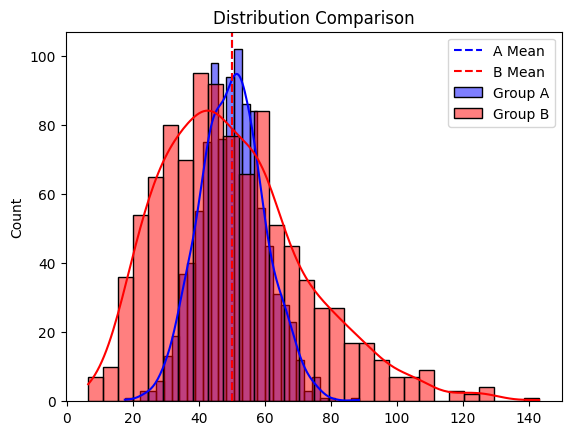

In [35]:
test_statistic(group_A, group_B, np.mean, 1000, "Mean")
plot_distributions(group_A, group_B, np.mean, "Mean")

Point estimate of 50th Percentile difference: 3.2623
Bootstrapped CI for 50th Percentile difference: (1.3031, 4.7284)


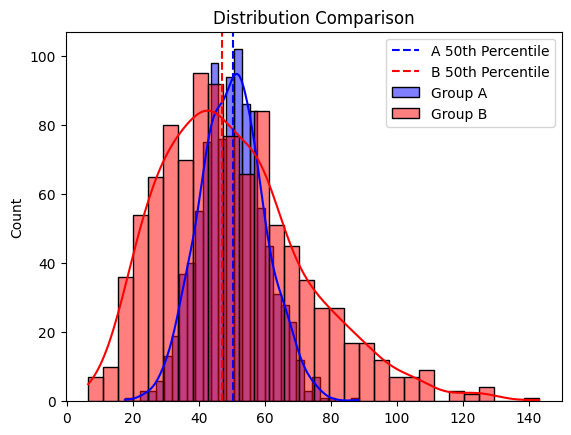

In [36]:
test_statistic(group_A, group_B, lambda x: np.quantile(x, 0.5), 1000, "50th Percentile")
plot_distributions(group_A, group_B, lambda x: np.quantile(x, 0.5), "50th Percentile")

# Множественная проверка гипотез и ее коррекция

Запускаем сразу несколько вариантов:
- 30% скидка
- 2 по цене 1

### Совет
Если можно не проводить множественный тест -- не проводить его.
1. сложная интерпретация
2. растущий FPR

### Нужно ли множественное тестирование в этом случае?
- Хотим смотреть основную метрику и guardrail
- Хотим посмотреть конверсию на разных шагах: из визита в добавление в корзину + из добавления в корзину в покупку

### FWER
Если сделать N тестов, то вероятность совершить хотя бы 1 ошибку первого рода в группе тестов (family-wise error rate) возрастает согласно формуле:
$$\text{FWER}=p(FP>0)=1-(1-\alpha)^m$$
, где m -- кол-во гипотез (сравнений). 

В случае с 3 гипотезами проверяем A/B, A/C, B/C:
$$\text{FWER}=1-(1-0.05)^3=0.142$$


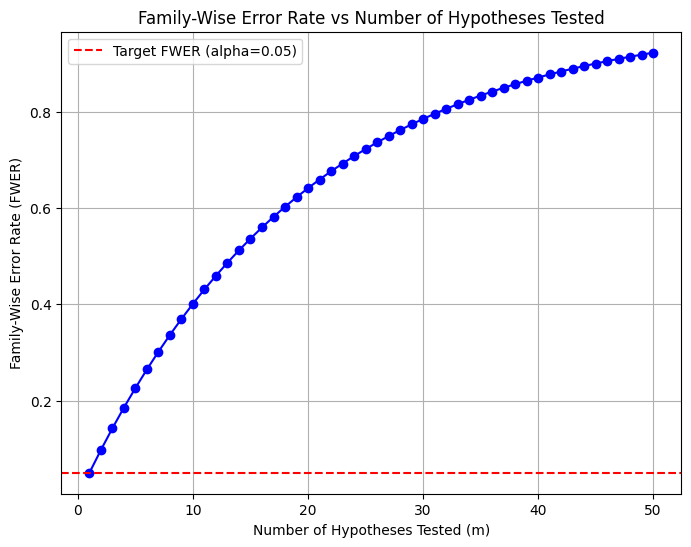

In [58]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.05
test_counts = np.arange(1, 51)

fwer_values = 1 - (1 - alpha) ** test_counts

plt.figure(figsize=(8, 6))
plt.plot(test_counts, fwer_values, marker="o", linestyle="-", color="b")
plt.axhline(y=0.05, color="r", linestyle="--", label="Target FWER (alpha=0.05)")
plt.xlabel("Number of Hypotheses Tested (m)")
plt.ylabel("Family-Wise Error Rate (FWER)")
plt.title("Family-Wise Error Rate vs Number of Hypotheses Tested")
plt.legend()
plt.grid(True)
plt.show()

Допустим мы провели эксперимент с 6 вариантами и применили статистический критерий

Итого: 15 попарных проверок (6*5)/2

In [37]:
# Получили следующие значения p-value:
p_values = np.array(
    [
        0.0029179437568,
        0.009391279264,
        0.011581441488,
        0.012616868376,
        0.02839967164,
        0.042167014336,
        0.04286582096,
        0.0956598092,
        0.10742021336,
        0.15927677808,
        0.19332229592,
        0.2456475724,
        0.254595706,
        0.28608461424,
        0.3626124616,
    ]
)

# Присвоим порядковые наименования для каждого из тестов
names = ["test" + str(i) for i in range(1, len(p_values) + 1)]
df = pd.DataFrame({"names": names, "p_values": p_values})
df

,names,p_values
0,test1,0.002918
1,test2,0.009391
2,test3,0.011581
3,test4,0.012617
4,test5,0.028400
5,test6,0.042167
6,test7,0.042866
7,test8,0.095660
8,test9,0.107420
9,test10,0.159277


#### 1. Поправка Бонферрони

Самый простой и интуитивно понятный метод для контроля FWER.

Итак, мы хотим контролировать FWER на уровнях значимости $\alpha_1..\alpha_m$. Наша задача выбрать $\alpha_1..\alpha_m$ так, чтобы $FWER  \le\alpha$. Тогда определим наши уровни значимости $\alpha_1..\alpha_m$ как $\alpha_i / m.$

$$\alpha^* = \frac{\alpha}{m}$$
- m -- кол-во тестов


#### 2. Поправка Холма

$$\alpha^*=\frac{\alpha}{m-k+1}$$

- m -- кол-во тестов
- k -- порядковый номер в отсортированном списке p-value

Минусы??

In [38]:
from statsmodels.sandbox.stats.multicomp import multipletests


alpha = 0.05
_, bonferroni_p, _, _ = multipletests(df.p_values, alpha=alpha, method="bonferroni")
df["bonferroni_p"] = bonferroni_p
df

,names,p_values,bonferroni_p
0,test1,0.002918,0.043769
1,test2,0.009391,0.140869
2,test3,0.011581,0.173722
3,test4,0.012617,0.189253
4,test5,0.028400,0.425995
5,test6,0.042167,0.632505
6,test7,0.042866,0.642987
7,test8,0.095660,1.000000
8,test9,0.107420,1.000000
9,test10,0.159277,1.000000


In [39]:
# коррекция Холма: более мощная поправка, чем Бонферонни
_, holm_p, _, _ = multipletests(df.p_values, method="holm")
df["holm_p"] = holm_p
df

,names,p_values,bonferroni_p,holm_p
0,test1,0.002918,0.043769,0.043769
1,test2,0.009391,0.140869,0.131478
2,test3,0.011581,0.173722,0.150559
3,test4,0.012617,0.189253,0.151402
4,test5,0.028400,0.425995,0.312396
5,test6,0.042167,0.632505,0.421670
6,test7,0.042866,0.642987,0.421670
7,test8,0.095660,1.000000,0.765278
8,test9,0.107420,1.000000,0.765278
9,test10,0.159277,1.000000,0.955661


**Проблема методов в том**, что таким образом мы сильно перестраховываемся в отношении ошибки I рода, тем самым пропуская истинные эффекты, то есть **уменьшаем мощность эксперимента с ростом числа гипотез**. 

Контроль FWER в некоторых ситуациях может быть неоправданно жестким, так как мы пытаемся контролировать совершить хотя бы одну ошибку I рода. Но мы также можем пытаться контролировать, например, **долю ложноположительных результатов**.

### FDR

FDR – это ожидаемая доля ложных отклонений от всех отклонений нулевых гипотез.

$$
FDR = \left(\frac{FP}{FP + TP}\right)
$$

С помощью FDR мы задаем не количество ошибок первого рода в принципе, а количество ложноположительных (fp) результатов в отношении к истинно-
положительным (tp) и ложноположительным (fp)

На интуитивном уровне отличие FDR от FWER в том, что FDR более "мягко" контролирует ошибку I рода, но также учитывает (в знаменателе) и ошибку II рода. За счет этого методы, контролирующие FDR, более мощные, но в то же время не так жестко контролируют ошибку I рода.


**Для контроля FDR используется поправка Бенджамини-Хохберга**


$$\alpha^*=\frac{k \times \alpha}{m}$$

- m -- кол-во тестов
- k -- порядковый номер в отсортированном списке p-value

In [40]:
# коррекция Бенджамини-Хохберга: коррекция FDR, самая мощная из представленных поправок
_, bh_p, _, _ = multipletests(df.p_values, method="fdr_bh")
df["bh_p"] = bh_p
df

,names,p_values,bonferroni_p,holm_p,bh_p
0,test1,0.002918,0.043769,0.043769,0.043769
1,test2,0.009391,0.140869,0.131478,0.047313
2,test3,0.011581,0.173722,0.150559,0.047313
3,test4,0.012617,0.189253,0.151402,0.047313
4,test5,0.028400,0.425995,0.312396,0.085199
5,test6,0.042167,0.632505,0.421670,0.091855
6,test7,0.042866,0.642987,0.421670,0.091855
7,test8,0.095660,1.000000,0.765278,0.179034
8,test9,0.107420,1.000000,0.765278,0.179034
9,test10,0.159277,1.000000,0.955661,0.238915


### FWER или FDR?
- FDR: выше мощность и контроль ложных срабатываний
- FWER: строгий контроль за вероятностью О1Р

Примерный вывод:
- Если имеется множество гипотез, из которых хочется выбрать наиболее "интересные" для дальнейшего анализа, можно опираться на FDR: так мы будем пропускать меньше реальных эффектов, а строгость в отношении ошибки I рода не так важна

- Если гипотез немного и тестируется фича, которая потенциально сильно может сказаться на ключевых метриках (например, на деньгах) как отрицательно (в особенности), так и положительно – надежней использовать FWER в силу его бОльшей консервативности в отношении ошибки I рода

Source: https://habr.com/ru/articles/772940/